# BNP Stock Price Forecast with ARIMA & LSTM

---

### Project Participant

* CAI Yutong
* EFREI Paris
* E-mail: yutong.cai@efrei.net

### Reference Material

* Get historical stock price from YAHOO! Finance: http://www.masterhsiao.com.tw/CatStocks/Stdev/Stdev.php
* YAHOO! Finance - BNP historical stock price: https://finance.yahoo.com/quote/BNP.PA?p=BNP.PA
* Understand the LSTM Network: https://www.jianshu.com/p/9dc9f41f0b29
* Time Series Prediction with LSTM: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

---

## PART 1. Import Dataset and Data Preprocessing

### 1.1. Import Dataset

In [1]:
import pandas as pd

In [2]:
stock = pd.read_csv('BNP.csv', index_col=0, parse_dates=[0])

### 1.2. Show Dataset Details

In [3]:
stock.head(10)

# 开盘(Open)、最高(High)、最低(Low)、收盘(Close)、调整后的收盘价(Adj Close)、成交量(Volume)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,45.523998,46.612598,45.523998,45.771400,19.543472,3712666.0
2000-01-04,45.227100,45.276600,44.237400,44.484901,18.994169,6404755.0
2000-01-05,44.039501,44.484901,43.049900,43.544701,18.592716,4837348.0
2000-01-06,43.544701,43.643700,42.060200,42.060200,17.958872,6594478.0
2000-01-07,42.307598,43.000401,42.159199,42.604500,18.191273,5929663.0
2000-01-10,43.099300,43.940601,42.851898,42.851898,18.296907,5758423.0
2000-01-11,43.247799,43.247799,41.169498,41.268501,17.620829,9474585.0
2000-01-12,41.070599,41.862301,40.773701,41.664398,17.789864,6548511.0
2000-01-13,41.565399,42.208698,41.466400,41.565399,17.747601,6213670.0


In [4]:
stock.shape

(4874, 6)

In [5]:
print('First Day: ', stock.index[0])
print('Last  Day: ', stock.index[-1])

First Day:  2000-01-03 00:00:00
Last  Day:  2018-12-10 00:00:00


### 1.3. Feature Selection & Data Resampling

In [6]:
stock_week = stock['Adj Close'].resample('W-MON').mean() 

# 选取收盘价(Adj Close)为样本数据
# 以周为单位周一开始重采样，以均值为计算标准

### 1.4. Split Dataset

In [7]:
stock_train = stock_week['2000':'2016']
stock_test = stock_week['2017':]

# 选择2000到2015年的股票数据作为训练集
# 选择2006年的股票数据作为测试集

### 1.5. Draw Training Data & Observation Data Trends

In [8]:
import matplotlib.pyplot as plt

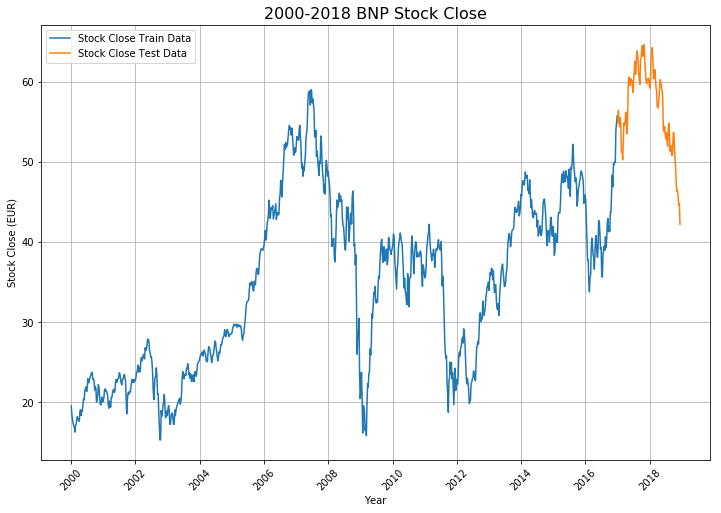

In [9]:
plt.figure(figsize=(12,8))

plt.plot(stock_train)
plt.plot(stock_test)

plt.title('2000-2018 BNP Stock Close', size=16)
plt.xlabel('Year')
plt.ylabel('Stock Close (EUR)') 

plt.xticks(rotation=45)

plt.legend(['Stock Close Train Data','Stock Close Test Data'])

plt.grid(True)
plt.show()

---

## Part 2. BNP Stock Price Forecast with ARIMA

### 2.1. Make First Order Difference or Second Order Difference

#### 2.1.1. Make First Order Difference

In [10]:
stock_train_diff = stock_train.diff()
stock_train_diff = stock_train_diff.dropna()

# 做一阶差分，让数据变化趋势变得平稳

#### 2.2.2. Plot the Training Data After the First Order Difference

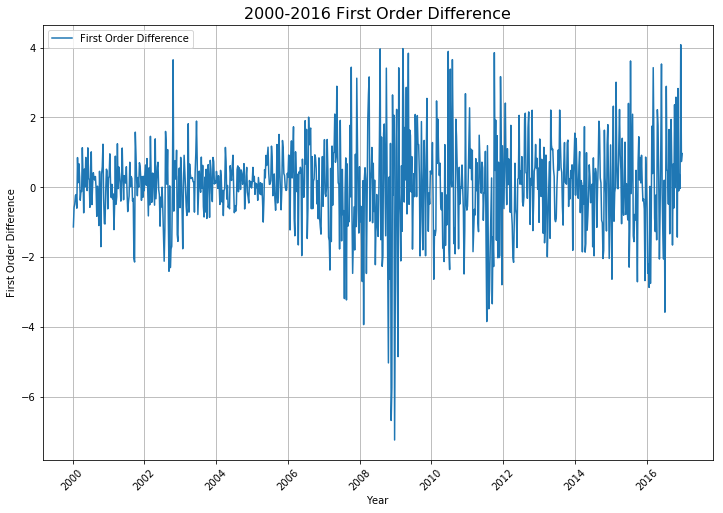

In [11]:
plt.figure(figsize=(12,8))
plt.plot(stock_train_diff)

plt.title('2000-2016 First Order Difference', size=16)
plt.xlabel('Year')
plt.ylabel('First Order Difference')

plt.xticks(rotation=45)

plt.legend(['First Order Difference'])

plt.grid(True)
plt.show()

# 根据观察一阶差分基本满足分析需求，不需再次进行二阶差分

### 2.2. Draw ACF&PACF Chart and Select Hyperparameter q&p

#### 2.2.1. Draw ACF Chart and Chose Hyperparameter q in MA Model

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

Text(0.5, 1.0, '2000-2016 ACF')

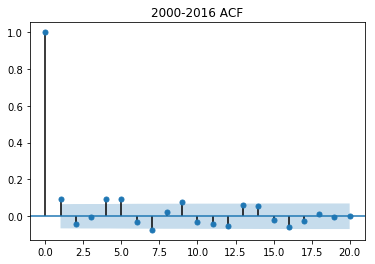

In [13]:
acf = plot_acf(stock_train_diff, lags=20)

plt.title("2000-2016 ACF")

#### 2.2.2. Draw PACF Chart and Chose Hyperparameter p in AR Model

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5, 1.0, '2000-2016 PACF')

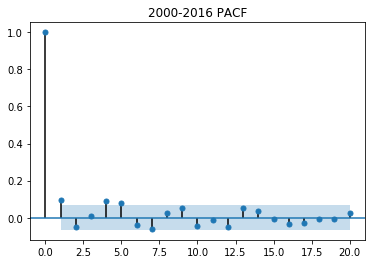

In [15]:
pacf = plot_pacf(stock_train_diff, lags=20)

plt.title("2000-2016 PACF")

### 2.3. Training ARIMA Model

In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [17]:
model = ARIMA(stock_train, order=(1, 1, 1),freq='W-MON')
result = model.fit()
print(result.summary())

# order=(p,d,q)

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  886
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1484.606
Method:                       css-mle   S.D. of innovations              1.293
Date:                Tue, 11 Dec 2018   AIC                           2977.213
Time:                        15:33:38   BIC                           2996.359
Sample:                    01-10-2000   HQIC                          2984.532
                         - 12-26-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0409      0.047      0.869      0.385      -0.051       0.133
ar.L1.D.Adj Close    -0.2195      0.238     -0.924      0.356      -0.685       0.246
ma.L1.D.Adj Close     0.

### 2.4. Use ARIMA Model to Predict Carrefour Stock Price After 2016

#### 2.4.1. Set the Forecast Period

In [18]:
start_date = str(stock_test.index[0])[0:10]
end_date = str(stock_test.index[-1])[0:10]

print('Training Data Start Date: ' + start_date)
print('Training Data  End  Date: ' + end_date)

Training Data Start Date: 2017-01-02
Training Data  End  Date: 2018-12-10


#### 2.4.2. Use ARIMA Model to Predict

In [19]:
stock_predict = result.predict(start_date, end_date, dynamic=True, typ='levels')
# print(stock_predict)

#### 2.4.3. Model evaluation

In [20]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

In [21]:
y_hat = np.array(stock_predict)
y_real = np.array(stock_test)

rmse = sqrt(mean_squared_error(y_real, y_hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.833


#### 2.4.4. Draw the Predict Result

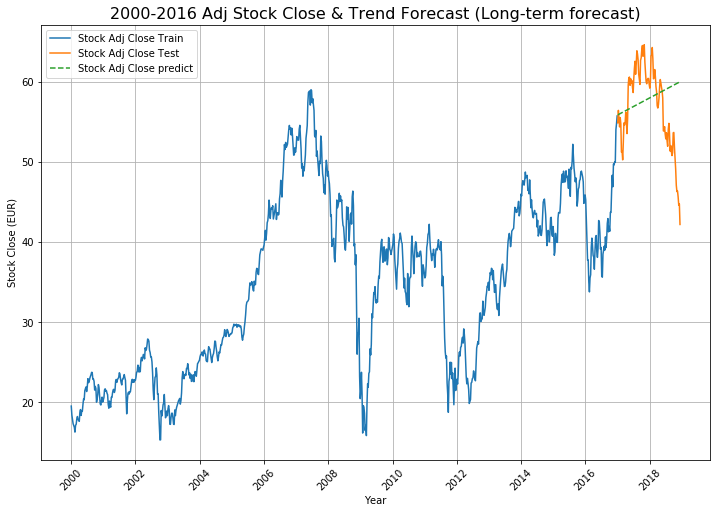

In [22]:
plt.figure(figsize=(12, 8))

plt.plot(stock_train)
plt.plot(stock_test)
plt.plot(stock_predict,'--')

plt.title('2000-2016 Adj Stock Close & Trend Forecast (Long-term forecast)', size=16)
plt.xlabel('Year')
plt.ylabel('Stock Close (EUR)')  

plt.xticks(rotation=45)

plt.legend(['Stock Adj Close Train', 'Stock Adj Close Test', 'Stock Adj Close predict'])

plt.grid(True)
plt.show()

### 2.5. Simulated Short-Term Forecast (Weekly Forecast)

#### 2.5.1. Use ARIMA Model to Predict

In [23]:
predict_list=pd.Series([])

for i in range(len(stock_test)):
    model = ARIMA(stock_week[0:i+len(stock_train)], order=(1, 1, 1),freq='W-MON')
    result = model.fit()
    y_predict = result.predict(str(stock_week.index[i+len(stock_train)])[0:10], dynamic=True, typ='levels')
    predict_list = predict_list.append(y_predict)

#### 2.5.2. Model evaluation

In [24]:
y_hat = np.array(predict_list)
y_real = np.array(stock_test)

rmse = sqrt(mean_squared_error(y_real, y_hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.353


#### 2.5.3. Draw the Predict Result

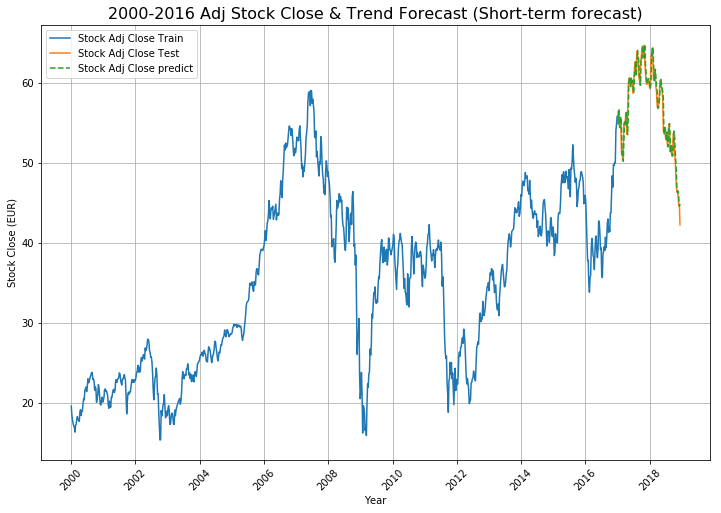

In [25]:
plt.figure(figsize=(12, 8))

plt.plot(stock_train)
plt.plot(stock_test)
plt.plot(predict_list,'--')

plt.title('2000-2016 Adj Stock Close & Trend Forecast (Short-term forecast)', size=16)
plt.xlabel('Year')
plt.ylabel('Stock Close (EUR)')  

plt.xticks(rotation=45)

plt.legend(['Stock Adj Close Train', 'Stock Adj Close Test', 'Stock Adj Close predict'])

plt.grid(True)
plt.show()

---

## Part 3. Carrefour Stock Price Forecast with LSTM

### 3.1. Prepare Data

In [26]:
all_data = stock_week.values.reshape(-1,1)
train_data = stock_train.values.reshape(-1,1)
test_data = stock_test.values.reshape(-1,1)

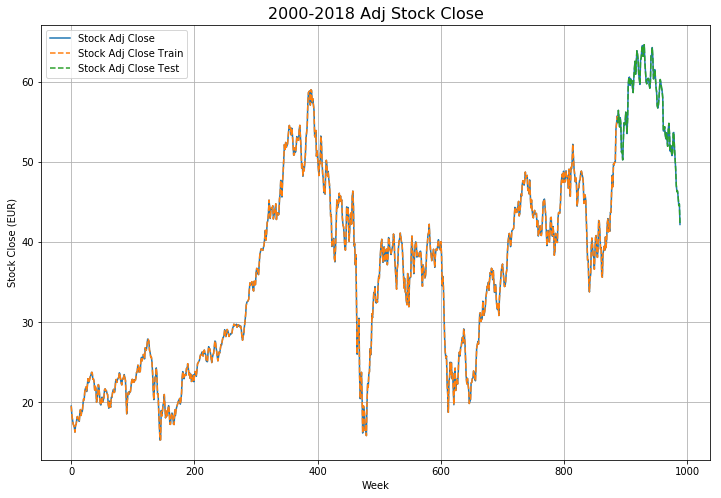

In [27]:
plt.figure(figsize=(12, 8))

trainDataPlot = np.empty_like(all_data)
trainDataPlot[:, :] = np.nan
trainDataPlot[0:len(train_data), :] = train_data

testDataPlot = np.empty_like(all_data)
testDataPlot[:, :] = np.nan
testDataPlot[len(train_data):len(all_data), :] = test_data

plt.plot(all_data,"-")
plt.plot(trainDataPlot,"--")
plt.plot(testDataPlot,"--")

plt.legend(['Stock Adj Close', 'Stock Adj Close Train', 'Stock Adj Close Test'])

plt.title('2000-2018 Adj Stock Close', size=16)
plt.xlabel('Week')
plt.ylabel('Stock Close (EUR)')  

plt.grid(True)
plt.show()

### 3.2. Data Normalization

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
minMaxScaler = MinMaxScaler(feature_range=(0, 1))

train_data_scale = minMaxScaler.fit_transform(train_data)
test_data_scale = minMaxScaler.transform(test_data)

### 3.3. Create Training Samples and Targets

In [30]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
# Window size: look_back

look_back = 3
X_train, Y_train = create_dataset(train_data_scale, look_back)
X_test, Y_test = create_dataset(test_data_scale, look_back)

### 3.4. Transform Data into LSTM Input Format

In [32]:
# reshape input to be [samples, time steps, features]

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### 3.5. Create & Train LSTM Model

In [33]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [34]:
model = Sequential()

model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_lstm , Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0424
Epoch 2/100
 - 2s - loss: 0.0023
Epoch 3/100
 - 2s - loss: 0.0016
Epoch 4/100
 - 2s - loss: 0.0015
Epoch 5/100
 - 2s - loss: 0.0014
Epoch 6/100
 - 2s - loss: 0.0014
Epoch 7/100
 - 2s - loss: 0.0013
Epoch 8/100
 - 2s - loss: 0.0013
Epoch 9/100
 - 2s - loss: 0.0012
Epoch 10/100
 - 2s - loss: 0.0011
Epoch 11/100
 - 2s - loss: 0.0011
Epoch 12/100
 - 2s - loss: 0.0011
Epoch 13/100
 - 2s - loss: 0.0010
Epoch 14/100
 - 2s - loss: 0.0010
Epoch 15/100
 - 2s - loss: 0.0010
Epoch 16/100
 - 2s - loss: 0.0010
Epoch 17/100
 - 2s - loss: 0.0010
Epoch 18/100
 - 2s - loss: 9.9798e-04
Epoch 19/100
 - 2s - loss: 0.0010
Epoch 20/100
 - 2s - loss: 9.9537e-04
Epoch 21/100
 - 2s - loss: 0.0010
Epoch 22/100
 - 2s - loss: 9.8022e-04
Epoch 23/100
 - 2s - loss: 0.0010
Epoch 24/100
 - 2s - loss: 0.0010
Epoch 25/100
 - 2s - loss: 9.8571e-04
Epoch 26/100
 - 2s - loss: 0.0010
Epoch 27/100
 - 2s - loss: 9.7934e-04
Epoch 28/100
 - 2s - loss: 9.9589e-04
Epoch 29/100
 - 2s - loss: 9.5807

### 3.6. Model Evaluation

In [35]:
# make predictions

train_predict = model.predict(X_train_lstm)
test_predict = model.predict(X_test_lstm)

In [36]:
# invert predictions

train_predict = minMaxScaler.inverse_transform(train_predict)
train_real = minMaxScaler.inverse_transform([Y_train])

test_predict = minMaxScaler.inverse_transform(test_predict)
test_real = minMaxScaler.inverse_transform([Y_test])

In [37]:
import math
from sklearn.metrics import mean_squared_error

In [38]:
# calculate root mean squared error

train_score = math.sqrt(mean_squared_error(train_real[0], train_predict[:,0]))
print('Train RMSE Score: %.2f' % (train_score))

test_score = math.sqrt(mean_squared_error(test_real[0], test_predict[:,0]))
print('Test  RMSE Score: %.2f' % (test_score))

Train RMSE Score: 1.35
Test  RMSE Score: 2.06


### 3.7. Draw Prediction Results

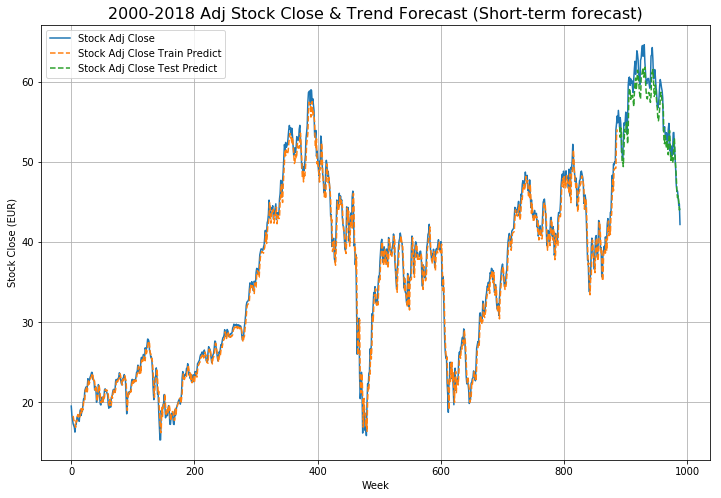

In [39]:
plt.figure(figsize=(12, 8))

trainPredictPlot = np.empty_like(all_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0 + look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(all_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(2*look_back):len(all_data), :] = test_predict

plt.plot(all_data,"-")
plt.plot(trainPredictPlot,"--")
plt.plot(testPredictPlot,"--")

plt.legend(['Stock Adj Close', 'Stock Adj Close Train Predict', 'Stock Adj Close Test Predict'])

plt.title('2000-2018 Adj Stock Close & Trend Forecast (Short-term forecast)', size=16)
plt.xlabel('Week')
plt.ylabel('Stock Close (EUR)')  

plt.grid(True)
plt.show()

---

# -END-